In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
import tensorflow_decision_forests as tfdf
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings('ignore')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


This project will involve analyzing what factors contributed to passengers of the famous Titanic surviving or not. We will be given information about the passengers such as their name, age, gender, socio-economic class and use a supervised model to create predictions. The point of this type of analysis is prevention and/or mitigation of these types of incidents in the future, and contributing to a greater understanding of how interpersonal differences can create mortality gaps between different populations. The dataset is acquired from Kaggle, it is not stated exactly where the information was drawn from but it is very likely that it is a processed version of various historical records from a source such as Encyclopedia Titanica, boarding records and survivor lists[1].

Let's start by retrieving the first few rows of the data.

In [2]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


The data details passenger information as you would expect, there are some values that might need some elaboration for clarity however out of the 12 columns.

"Survived" denotes whether the passenger survived the Titanic ordeal, with "1" signifying survival and "0" signifying death.

"PClass" denotes what class of ticket it was, the options being from 1 to 3, 1 being upper, 2 being middle and 3 being lower. This can be used as a proxy for socio-economic status.

"SibSp" denotes the amounts of siblings and spouses aboard.

"Parch" denotes the number of parents and children aboard.

"Ticket" denotes the ticket number.

"Fare" denotes the revenue generated by the passenger.

"Cabin" denotes the cabin number.

"Embarked" denotes the port of embarkation, the options being "S", "C" and "Q", denoting Southampton, Cherbourg and Queenstown.

We will display the total amount of rows and size of the training data to determine the scope of the dataset.

In [4]:
n_rows_train = len(train_data)
n_cols_train = train_data.shape[1]

n_rows_test = len(test_data)
n_cols_test = test_data.shape[1]

memory_usage_train = train_data.memory_usage(deep=True).sum()
memory_usage_test = test_data.memory_usage(deep=True).sum()

print(f"Train dataset: {n_rows_train} rows × {n_cols_train} columns")
print(f"Train dataset size: {memory_usage_train / 1024:.2f} KB")
print(f"\nTest dataset: {n_rows_test} rows × {n_cols_test} columns")
print(f"Test dataset size: {memory_usage_test / 1024:.2f} KB")

Train dataset: 891 rows × 12 columns
Train dataset size: 315.03 KB

Test dataset: 418 rows × 11 columns
Test dataset size: 144.80 KB


Next we will do some data cleaning based on what we see in the table.

Age seems to be an important feature and it is important that there aren't any values missing in the dataset or else it might derail our model, we will fill any missing values with the median age to keep the data consistent.

We will drop certain columns that don't seem to have predictive power, or have too many NaN values such as "Name", "Ticket", "PassengerId" and "Cabin".

Finally we will make certain columns that do seem to have predictive power numeric so that they can be modeled. We will do this for "Sex" and "Embarked"

In [5]:
train = train_data.copy()
test = test_data.copy()

# Fills in missing values with median age
train.loc[:, 'Age'] = train['Age'].fillna(train['Age'].median())
test.loc[:, 'Age'] = test['Age'].fillna(test['Age'].median())

# Drops Name, Ticket, PassengerId and Cabin columns
columns_to_drop = ['Name', 'Ticket', 'PassengerId', 'Cabin']
train = train.drop(columns=columns_to_drop, axis=1)
test = test.drop(columns=columns_to_drop, axis=1)

# Makes Sex and Embarked columns numerical
label_encoder = LabelEncoder()
for column in ['Sex', 'Embarked']:
    train.loc[:, column] = label_encoder.fit_transform(train[column])
    test.loc[:, column] = label_encoder.transform(test[column])

print("Training data shape:", train.shape)
print("Test data shape:", test.shape)

Training data shape: (891, 8)
Test data shape: (418, 7)


We have ended up with a dataset with fewer columns. Now that we have a cleaner dataset we can visualize it to see if we can draw some conclusions. We will create some histogram plots to see which values are the most common in the dataset, we will create a correlation matrix with a heatmap to see which features are correlated to each other and finally we will create bar plots for Sex and Passenger Class to see how those now numerical features are correlated to survival in particular.

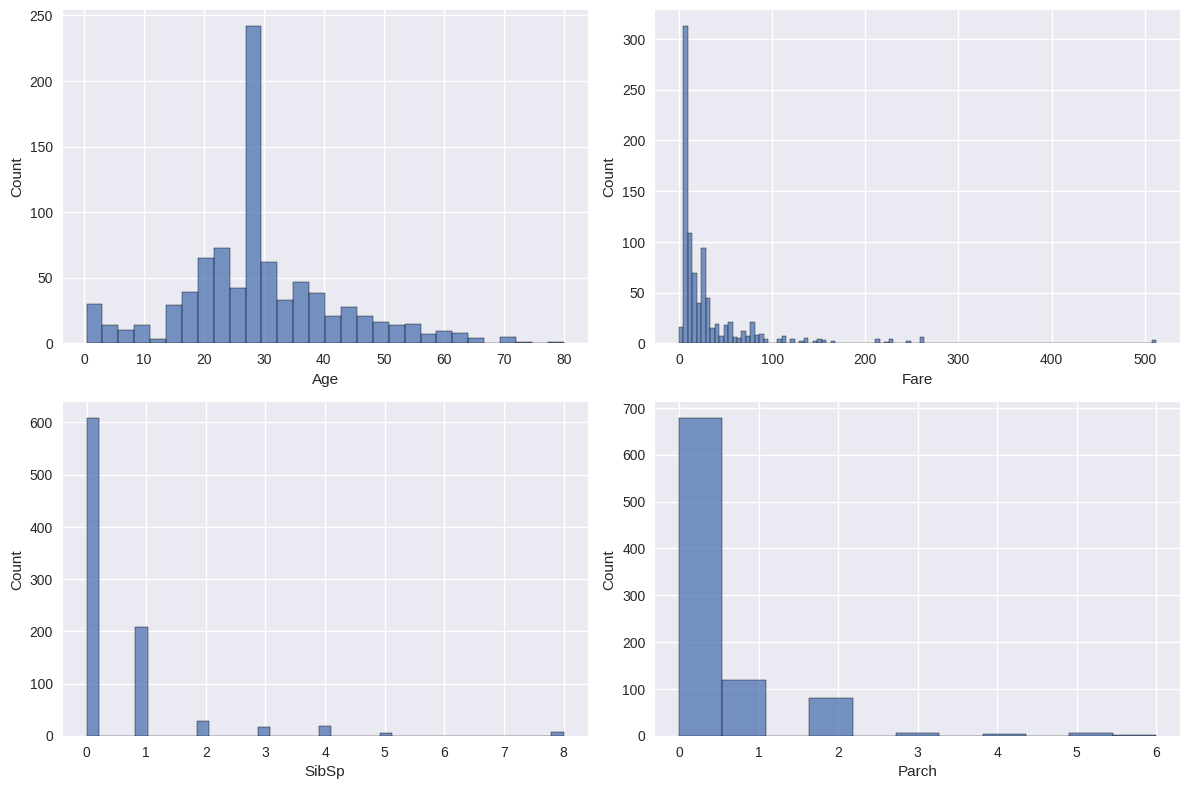

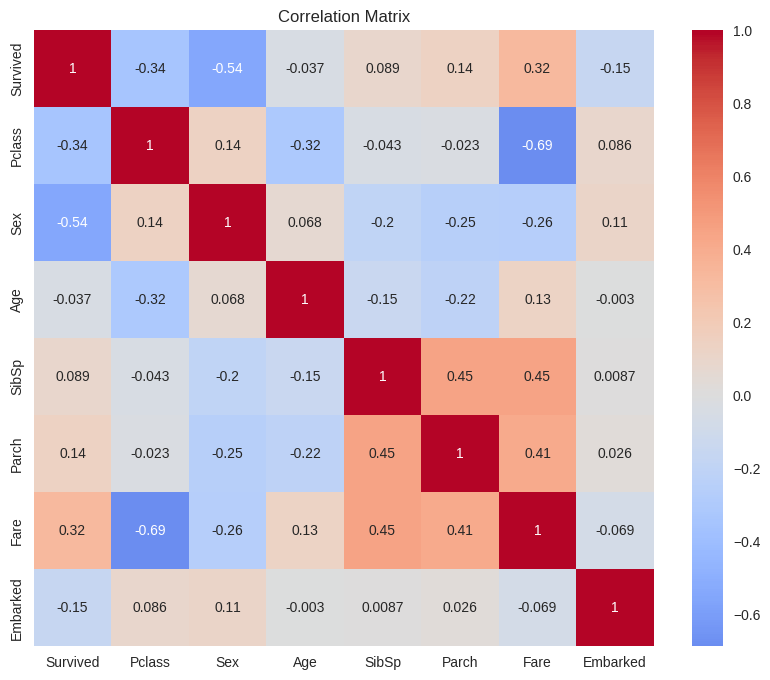

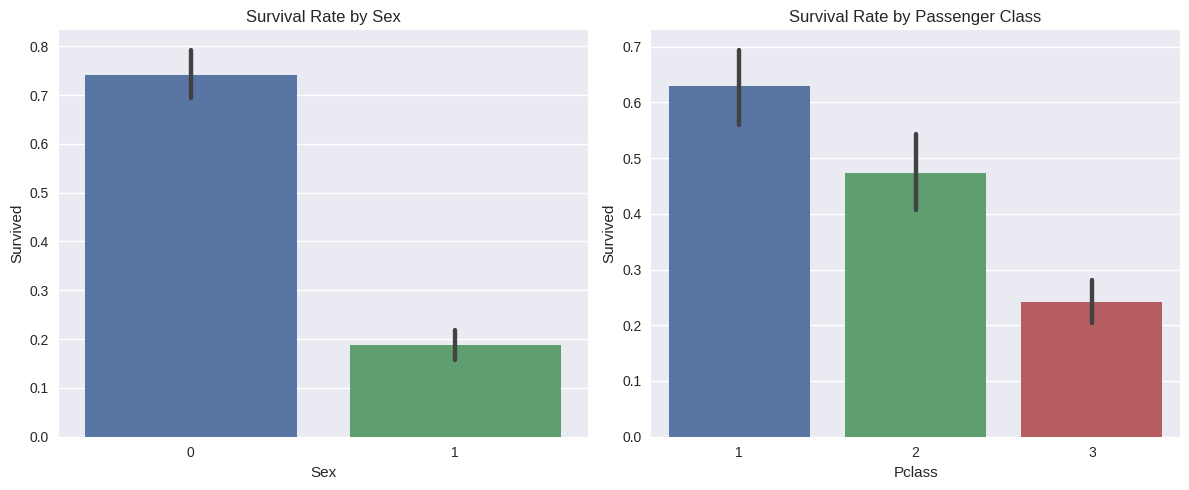

In [47]:
# 1. Plot a histogram
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(data=train, x='Age', ax=axes[0,0])
sns.histplot(data=train, x='Fare', ax=axes[0,1])
sns.histplot(data=train, x='SibSp', ax=axes[1,0])
sns.histplot(data=train, x='Parch', ax=axes[1,1])
plt.tight_layout()
plt.show()

# 3. Correlation matrix with a heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = train.corr(method='spearman')
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

# 4. Bar plot for survival rate by features
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.barplot(data=train, x='Sex', y='Survived', ax=axes[0])
axes[0].set_title('Survival Rate by Sex')
sns.barplot(data=train, x='Pclass', y='Survived', ax=axes[1])
axes[1].set_title('Survival Rate by Passenger Class')
plt.tight_layout()
plt.show()

It seems the average ages of the passengers were people in theirs 20s to 30s, there is a significant spike around the 30 mark which I believe signifies the median ages we added in our data cleaning procedure. The average fare was quite low and most people elected to pay as little as possible for the trip, other than one person who seems to have extravagantly spent around 500. Most people had no siblings or spouses aboard, the second most frequent being having a single one aboard, the same is true of parents or children. A lot of the data isn't normally distributed hence Spearman correlation is preferable to the default Pearson correlation that Pandas uses.

According to the heatmap the most correlated things for survival was sex, meaning being a woman increased chances significantly. The second most correlated was passenger class, which is a proxy for socio-economic status and means that wealthier people survived more on average. Finally fare and passenger class are negatively correlated but this seems trivial since a higher class ticket would cost more.

In the bar plot our suspiciouns about sex and class are confirmed quite clearly, the passenger class in particular seems to have a linear increase of survival chance based on how high your ticket class was, meaning second class tickets were in the middle of the survival range, it seems you could roughly triple your chances of survival by buying a first class ticket rather than third class.

Based on this data I believe a Random Forest or Decision Tree model would suit the data. These models would deal well with having a mix of innately numeric and numerized categorical features, clear decision boundaries (strong correlation between sex, class and survival), relationships between features that aren't purely linear, and missing values. Random Forest models in particular are good at preventing overfitting to spikes such as the ones in the age column, and it should be able to handle outliers such as in the lower end of the fare distribution.

According to Alexis Cook, a Random Forest is a model that is constructed of several "trees" that will individually consider each passenger's data and vote on whether the individual survived. Then, the random forest model makes a democratic decision: the outcome with the most votes winnning [2].

A Decision Tree model instead is a single tree that splits based on features, at each node it picks the best feature to split on (in this case most likely age and class), and makes decisions in a hierarchical rather than a democratic way. It is simpler than Random Forest which uses many trees but is more prone to overfitting due to attempting to fit all training data [3].

We will start with a pre-processing, training and modelling a Decision Tree model.

Accuracy: 0.8260869383811951 Loss:0.9144726395606995


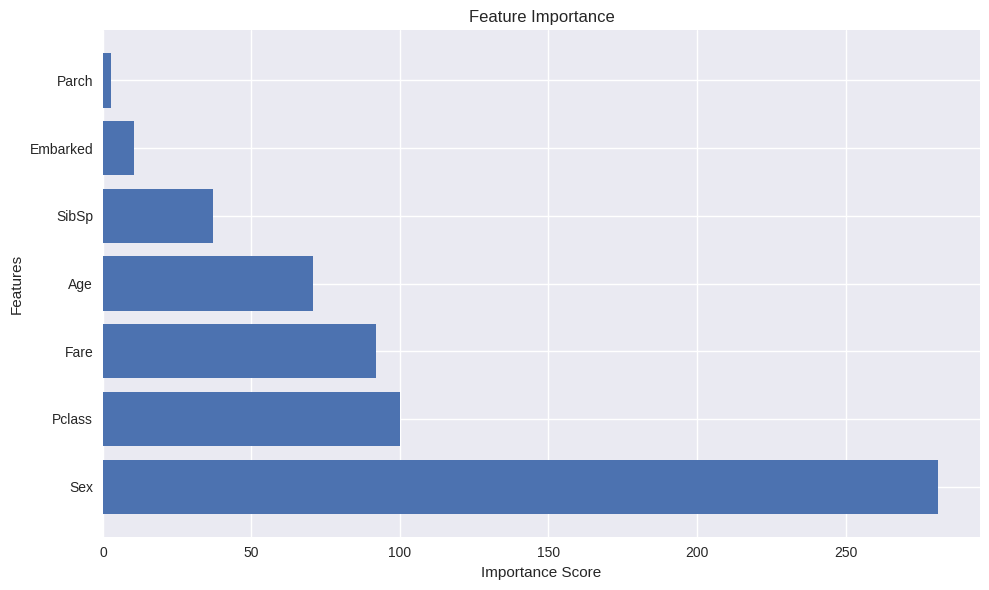

In [42]:
# Define our input features based on our cleaned data
input_features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

# Convert to TensorFlow datasets
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train, label="Survived")
serving_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test)

# Create and train the model
model = tfdf.keras.GradientBoostedTreesModel(
    verbose=0,
    features=[tfdf.keras.FeatureUsage(name=n) for n in input_features],
    exclude_non_specified_features=True,
    random_seed=1234,
)
model.fit(train_ds)

# Evaluate the model
self_evaluation = model.make_inspector().evaluation()
print(f"Accuracy: {self_evaluation.accuracy} Loss:{self_evaluation.loss}")

# Add feature importance visualization
importance = model.make_inspector().variable_importances()["SUM_SCORE"]
features = [imp[0].name for imp in importance]
scores = [imp[1] for imp in importance]

plt.figure(figsize=(10, 6))
plt.barh(features, scores)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

The accuracy and loss are quite good and indicates the model learned patterns but most likely didn't overfit. The results align with our EDA which showcased features with strong predictive potential such as sex and class.

We can try implementing a Random Forest model next.

Accuracy: 0.8181818181818182 Loss:2.4566359912577336


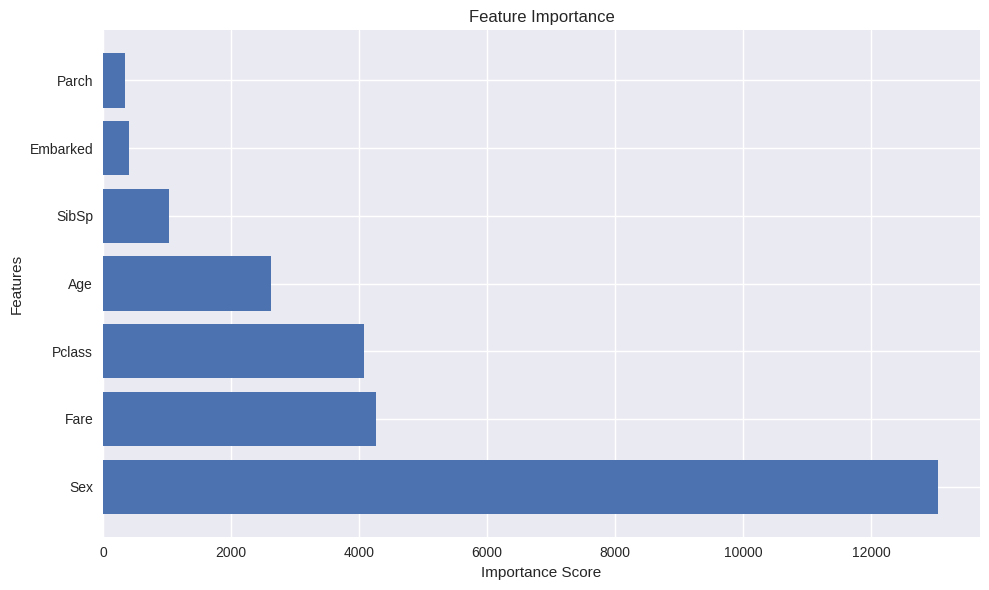

In [43]:
# Define input features
input_features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

# Convert to TensorFlow datasets 
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train, label="Survived")
serving_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test)

# Create and train Random Forest model
model = tfdf.keras.RandomForestModel(
    verbose=0,
    features=[tfdf.keras.FeatureUsage(name=n) for n in input_features],
    exclude_non_specified_features=True,
    random_seed=1234,
    num_trees=100,
    max_depth=5
)
model.fit(train_ds)

# Evaluate the model
self_evaluation = model.make_inspector().evaluation()
print(f"Accuracy: {self_evaluation.accuracy} Loss:{self_evaluation.loss}")

# Add feature importance visualization
importance = model.make_inspector().variable_importances()["SUM_SCORE"]
features = [imp[0].name for imp in importance]
scores = [imp[1] for imp in importance]

plt.figure(figsize=(10, 6))
plt.barh(features, scores)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

The accuracy is still quite good however the loss is far higher now, this most likely points to overfitting of the model. We will attempt hyperparameter tuning to reduce this loss and have less overfitting. We will do this by reducing the depth of the model, we will also increase the amount of trees to compensate for this depth reduction. 

Reducing depth makes each tree shorter which means fewer splits in the tree. This creates trees with less complex decisions being made which reduces the chance of overfitting since there won't be as many specific decisions being made, however this is at the cost of less fine-grained details being captured and therefore potentially lower accuracy.

We added more trees because this means more "votes" which increases the stability of the model and can compensate for the reduced depth, making up for the lower accuracy to some extent.

Accuracy: 0.8103254769921436 Loss:1.9450597928901747


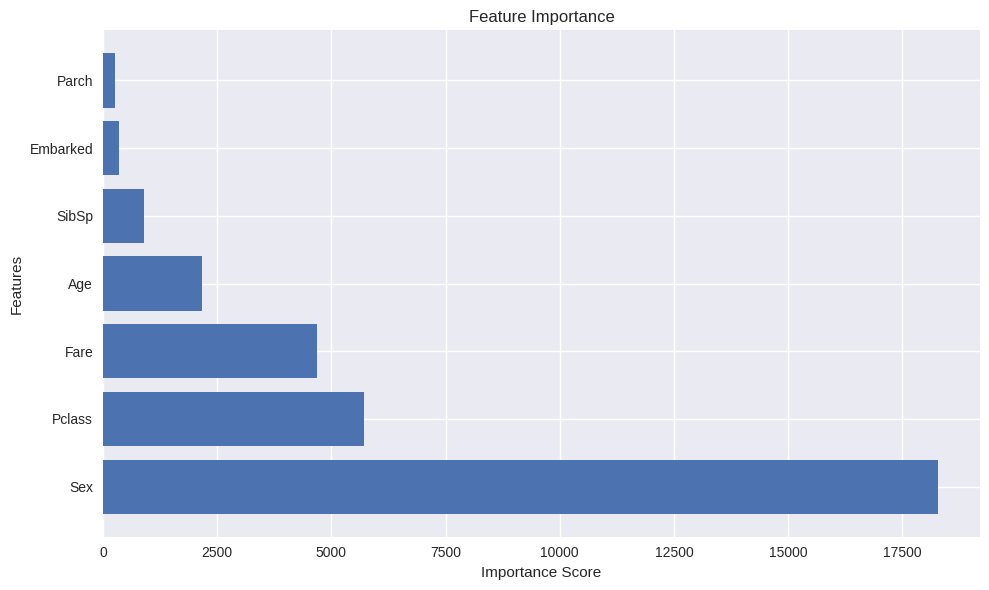

In [44]:
# Define input features
input_features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

# Convert to TensorFlow datasets 
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train, label="Survived")
serving_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test)

model = tfdf.keras.RandomForestModel(
    verbose=0,
    features=[tfdf.keras.FeatureUsage(name=n) for n in input_features],
    exclude_non_specified_features=True,
    random_seed=1234,
    num_trees=150,
    max_depth=4
)
model.fit(train_ds)

# Evaluate the model
self_evaluation = model.make_inspector().evaluation()
print(f"Accuracy: {self_evaluation.accuracy} Loss:{self_evaluation.loss}")

# Add feature importance visualization
importance = model.make_inspector().variable_importances()["SUM_SCORE"]
features = [imp[0].name for imp in importance]
scores = [imp[1] for imp in importance]

plt.figure(figsize=(10, 6))
plt.barh(features, scores)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

Our hyperparameter tuning has achieved its goal of reducing the loss without impacting the accuracy very significantly. However this result is still worse than the Decision Tree model we ran at first, which actually goes against our assumptions in the EDA.

In conclusion it seems the Decision Tree model was the best fit for the data. This is likely because of feature importance being relegated to a few important metrics rather than being a synthesis of many different variables. In cases such as this a single well tuned decision tree is preferable since it can capture all detail related to a simple correlation such as this, the Random Forest model's ability to combine knowledge from many different trees is somewhat wasted on this type of dataset. The accuracy and loss could most likely have been improved even further through some hyperparameter tuning to make the Decision Tree model even more simple and prevent overfitting to a greater extent.

References:

[1] Will Cukierski. Titanic - Machine Learning from Disaster. https://kaggle.com/competitions/titanic, 2012. Kaggle.

[2] Alexis Cook. Titanic Tutorial. https://www.kaggle.com/code/alexisbcook/titanic-tutorial, 2022. Kaggle.

[3] Gusthema. Titanic Competition w/ Tensorflow Decision Forests. https://www.kaggle.com/code/gusthema/titanic-competition-w-tensorflow-decision-forests, 2023. Kaggle.